<a href="https://colab.research.google.com/github/sayoneenandi/waiting_in_aNe/blob/main/Copy_of_waiting_in_a_and_e_after_adding_rolling_average_ed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
historic_ratio=pd.read_excel("/content/IC-02 Historical Ratio.xlsx")
historic_ratio.head()

,Time,Ratio Admission to Attendance
0,1,0.356605
1,2,0.340786
2,3,0.330214
3,4,0.324555
4,5,0.344071


# rolling average ed attendance

In [90]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from math import ceil
!pip install mplcursors
import mplcursors

class RollingAverageEDattendance:
    def __init__(self, historical_attendance, baseline_date):
        self.historical_attendance = historical_attendance
        self.baseline_date = baseline_date

        self.average_emergency_attendances = None
        self.rolling_avg_period = len(historical_attendance)

        self.data_delayed = [historical_attendance['IC-02 Historical Emergency Attendances'].iloc[0] for _ in range(self.rolling_avg_period)]
        self.historical_std_dev = np.std(historical_attendance['IC-02 Historical Emergency Attendances'])

    def delay(self, new_value):
        self.data_delayed.pop(0)
        self.data_delayed.append(new_value)
        return self.data_delayed[0]

    def calculate_delay_factor(self, current_time):
        if current_time < self.baseline_date:
            return self.historical_attendance.loc[current_time]['IC-02 Historical Emergency Attendances']
        else:
            return self.delay(self.historical_attendance.loc[current_time]['IC-02 Historical Emergency Attendances'])

    def average_emergency(self, current_time, weekly_data):
        if current_time < self.baseline_date:
            return weekly_data
        else:
            rolling_avg_emergency = self.cumulative / self.rolling_avg_period
            std_dev_emergency = self.calculate_std_dev(current_time)
            return np.random.normal(rolling_avg_emergency, std_dev_emergency)

    def rolling_average_ed_attendance_avg_Emg_attendances(self, current_time):
        weekly_data = self.historical_attendance.loc[current_time]['IC-02 Historical Emergency Attendances']
        self.rolling_avg_period = len(self.historical_attendance.loc[:current_time])
        rolling_avg_emergency = self.cumulative / self.rolling_avg_period

        self.average_emergency_attendances = self.average_emergency(current_time, weekly_data)
        return self.average_emergency_attendances

    def calculate_std_dev(self, current_time):
        recent_attendance = self.historical_attendance['IC-02 Historical Emergency Attendances'][-self.rolling_avg_period:]
        return np.std(recent_attendance)

    def calculate_weekly_variation(self, date, weekly_data):
        if date < self.baseline_date:
            return abs(weekly_data - self.cumulative / self.rolling_avg_period)
        else:
            return 0

    def run_simulation(self, start_time, end_time, dt_denominator):
        dates = DynamicModel.time(dt_denominator, start_time, end_time)  # Use DynamicModel's static time method here
        forecast = []
        rolling_avg = []
        std_dev = []
        self.cumulative = 0
        self.deviation = 0

        for date in dates:
            rolling_avg_emergency = self.rolling_average_ed_attendance_avg_Emg_attendances(date)
            weekly_data_cumulative_inflow = rolling_avg_emergency
            weekly_variation_deviation_inflow = self.calculate_weekly_variation(date, rolling_avg_emergency)

            dt = 1  # Assuming time step of 1 week
            self.cumulative = self.cumulative + dt * (weekly_data_cumulative_inflow - self.cumulative / self.rolling_avg_period)
            self.deviation = self.deviation + dt * weekly_variation_deviation_inflow

            std_dev_emergency = self.calculate_std_dev(date)
            forecast.append(rolling_avg_emergency)
            rolling_avg.append(rolling_avg_emergency)
            std_dev.append(std_dev_emergency)

        return forecast, rolling_avg, std_dev



# Rolling Average Ratio Admission to Attendance

In [91]:
class RollingAverageAdmissionToAttendanceRatio:
    def __init__(self, historical_ratio, baseline_date):
        global rolling_avg_period_ratio_attendances, weeks_in_year, reduction_non_elective_admission_to_attendance_rate, time_in_weeks_to_reach_reduction

        self.historical_ratio = historical_ratio
        self.baseline_date = baseline_date
        self.rolling_avg_period_ratio_attendances = rolling_avg_period_ratio_attendances
        self.weeks_in_year = weeks_in_year
        self.reduction_non_elective_admission_to_attendance_rate = reduction_non_elective_admission_to_attendance_rate
        self.time_in_weeks_to_reach_reduction = time_in_weeks_to_reach_reduction
        self.data_delayed = [historical_ratio['Ratio Admission to Attendance'].iloc[0] for _ in range(self.rolling_avg_period_ratio_attendances)]
        self.cumulative = 0

    def delay(self, new_value):
        self.data_delayed.pop(0)
        self.data_delayed.append(new_value)
        return self.data_delayed[0]

    def timestamp_to_week_num(self, timestamp):
        return int((timestamp - self.baseline_date).days / 7)

    def weekly_los(self, week_num):
        try:
            return self.historical_ratio.set_index('Time').loc[week_num]['Ratio Admission to Attendance']
        except KeyError:
            return 0

    def outofdatedata(self, week_num):
        try:
            if week_num < self.timestamp_to_week_num(self.baseline_date):
                return self.historical_ratio.set_index('Time').loc[week_num]['Ratio Admission to Attendance']
            else:
                return self.delay(self.historical_ratio.set_index('Time').loc[week_num]['Ratio Admission to Attendance'])
        except KeyError:
            return 0
    def update(self, new_data_point):
        """
        Append new data to historical_ratio.
        :param new_data_point: DataFrame row containing new data.
        """
        self.historical_ratio = self.historical_ratio.append(new_data_point, ignore_index=True)
    def calculate_ratio(self, date):
        # Temporary simple calculation
        number_of_weeks = (date - self.baseline_date).days // 7
        ratio = 0.2 - 0.01 * (number_of_weeks / 52)

        # Ensure ratio stays between 0 and 1
        if ratio < 0:
            ratio = 0
        if ratio > 1:
            ratio = 1

        return ratio
    def run_simulation(self, start_time, end_time, dt):
        dates = pd.date_range(start=start_time, end=end_time, freq="W").tolist()  # Weekly frequency
        ratios = []

        for date in dates:
            week_num = self.timestamp_to_week_num(date)
            los = self.weekly_los(week_num)
            outdated = self.outofdatedata(week_num)

            # Modified Cumulative Calculation
            potential_cumulative = self.cumulative + dt * (los - outdated)
            self.cumulative = max(0, potential_cumulative)

            ramp_value = self.reduction_non_elective_admission_to_attendance_rate / (100 * self.weeks_in_year)
            if date >= self.baseline_date and date <= self.baseline_date + timedelta(weeks=self.time_in_weeks_to_reach_reduction):
                ramp_factor = ramp_value
            else:
                ramp_factor = 0

            ratio = self.cumulative / self.rolling_avg_period_ratio_attendances * (1 - ramp_factor)
            ratios.append(ratio)
            print(f"Date: {date}, LOS: {los}, Outdated: {outdated}, Cumulative: {self.cumulative}, Ramp: {ramp_factor}")
            print(f"Ratio for {date}: {ratio}")

        return ratios



# waiting and a and e stock

In [101]:
class DynamicModel:
    @staticmethod
    def time(dt_denominator, start_time, end_date_sim):
        dt = 1.0 / dt_denominator
        time_increment = timedelta(weeks=int(13))  # Quarterly means every 13 weeks
        num_weeks = (end_date_sim - start_time).days // 7
        end_time = start_time + timedelta(weeks=int(num_weeks // dt_denominator))
        return pd.date_range(start=start_time, end=end_time, freq=time_increment).tolist()


    def __init__(self,A_and_E_Attendances=0, historical_attendance=[], start_time_sim=None, end_date_sim=None):
        self.A_and_E_Attendances = A_and_E_Attendances
        self.historical_attendance = historical_attendance
        self.start_time_sim = start_time_sim if start_time_sim is not None else datetime.now()
        self.end_date_sim = end_date_sim
        self.current_time = None
        self.dt = dt
        self.historical_forecast_attendances = []
        # Create rolling_avg_forecast internally
        self.rolling_avg_forecast = RollingAverageEDattendance(self.historical_attendance, self.start_time_sim)

    def get_admission_to_attendance_ratio(self):
        global baseline_date
        global historic_ratio
        global rolling_avg_ratio

        current_time_week_num = int((self.current_time - baseline_date).days / 7)

        # Decide the source of the ratio based on the current time
        if self.current_time < baseline_date:
            try:
                return historic_ratio.set_index('Time').loc[current_time_week_num]['Ratio Admission to Attendance']
            except KeyError:
                return 0  # Default value in case the week is not found
        else:
            # Calculate using the RollingAverageAdmissionToAttendanceRatio class
            # Assuming the run_simulation method gives the ratios as a list and the last ratio in the list is the current ratio
            ratios = rolling_avg_ratio.run_simulation(baseline_date, self.current_time, self.dt)
            return ratios[-1] if ratios else 0  # Default value if ratios list is empty

    def calculate_PatientsNadmission(self, forecast_attendance):
        admission_to_attendance_ratio = self.get_admission_to_attendance_ratio()
        ratio = admission_to_attendance_ratio

        print(f"Ratio: {ratio}")

        delay_days = avg_time_in_A_and_E_hours / (hours_in_a_day * days_in_a_week)
        patients_needing_admission_raw = pd.to_numeric(forecast_attendance) * admission_to_attendance_ratio * delay_days
        patients_needing_admission = patients_needing_admission_raw  # Removed ceil here

        delay = delay_days
        print(f"Delay: {delay}")
        print(f"Debug - calculate_PatientsNadmission: Forecast Attendance: {forecast_attendance}, Delay Days: {delay_days}")
        print(f"Debug - Patients Needing Admission: {patients_needing_admission}")

        return patients_needing_admission



    def calculate_AEnoreqAttendance(self, forecast_attendance):
        admission_to_attendance_ratio = self.get_admission_to_attendance_ratio()

        delay_days = avg_time_in_A_and_E_hours / (hours_in_a_day * days_in_a_week)
        patients_not_required_admission = pd.to_numeric(forecast_attendance) * (1 - admission_to_attendance_ratio) * delay_days

        print(f"Debug - calculate_AEnoreqAttendance: Forecast Attendance: {forecast_attendance}, Delay Days: {delay_days}")
        print(f"Debug - Patients Not Required Admission: {patients_not_required_admission}")

        return patients_not_required_admission

    def calculate_AEattendance(self, current_time):
        print(f"Debug - calculate_AEattendance: Current Time: {current_time}")

        if current_time < self.start_time_sim:
            # Return Rolling_average_ED_attendance instead of last historical value
            return self.rolling_avg_forecast.rolling_average_ed_attendance_avg_Emg_attendances(current_time)

        else:
            max_historical_time = pd.Timestamp(max(self.historical_attendance["Time"]))  # <--- This line is added

            if current_time <= max_historical_time:  # <--- And this line is modified
                # If still within historical data range, use actual attendance
                index = self.historical_attendance["Time"].tolist().index(current_time)
                return self.historical_attendance["IC-02 Historical Emergency Attendances"].iloc[index]

            else:
                # After historical data, forecast using growth rate
                weeks_after_baseline = (current_time - self.start_time_sim).days // 7
                growth_rate_per_week = (1 + self.annual_population_growth_rate) ** (1/weeks_in_year) - 1
                return self.historical_attendance["IC-02 Historical Emergency Attendances"].iloc[-1] * (1 + growth_rate_per_week) ** weeks_after_baseline

    def waiting_in_a_n_e(self):
        print(f"Debug - waiting_in_a_n_e: Start Time: {self.start_time_sim}")
        print(f"Debug - waiting_in_a_n_e: End Date: {self.end_date_sim}")

        self.AEattendance = self.historical_attendance["IC-02 Historical Emergency Attendances"].tolist()
        self.time_values = DynamicModel.time(4, self.start_time_sim, self.end_date_sim)
       #self.historical_forecast_attendances.append(forecast_attendance)
        all_time_steps = []
        all_net_flow_values = []
        all_inflow_values = []
        all_outflow_values = []
        all_patients_needing_admission_values = []

        for current_time in self.time_values:
            self.current_time = current_time
            print(f"Debug - waiting_in_a_n_e: Current Time: {current_time}")

            forecast_attendance = self.calculate_AEattendance(current_time)
            print(f"Debug - waiting_in_a_n_e: Forecast Attendance: {forecast_attendance}")
            patients_needing_admission = self.calculate_PatientsNadmission(forecast_attendance)
            patients_not_required_admission = self.calculate_AEnoreqAttendance(forecast_attendance)

            #patients_needing_admission = self.calculate_PatientsNadmission()
            print(f"Debug - waiting_in_a_n_e: Patients Needing Admission: {patients_needing_admission}")

            #patients_not_required_admission = self.calculate_AEnoreqAttendance()
            print(f"Debug - waiting_in_a_n_e: Patients Not Required Admission: {patients_not_required_admission}")

            inflow_value = forecast_attendance
            outflow_value = patients_needing_admission + patients_not_required_admission
            net_flow_value = inflow_value - outflow_value

            all_time_steps.append(current_time)
            all_net_flow_values.append(net_flow_value)
            all_inflow_values.append(inflow_value)
            all_outflow_values.append(outflow_value)
            all_patients_needing_admission_values.append(patients_needing_admission)
            self.historical_forecast_attendances.append(forecast_attendance)
            print(f"Debug - waiting_in_a_n_e: Current Time: {current_time}, Net Flow: {net_flow_value}, Inflow: {inflow_value}, Outflow: {outflow_value}, Patients Needing Admission: {patients_needing_admission}")

            self.AEattendance.append(inflow_value)  # Append inflow_value to AEattendance

        return all_time_steps, all_net_flow_values, all_inflow_values, all_outflow_values, all_patients_needing_admission_values


2nd block

In [102]:


# Replace the following values with the actual data
baseline_date = datetime(2028, 1, 1)
weeks_in_year = 52
sim_time = 676
dt_denominator = 1  # Time step denominator (quarterly)
dt = 1.0 / dt_denominator  # Calculate dt based on dt_denominator
#rolling_average_ed_attendance_avg_Emg_attendances = 1700
annual_population_growth_rate = 1.2
baseline = 208
avg_time_in_A_and_E_hours = 4
hours_in_a_day = 24
days_in_a_week = 7
rolling_avg_period_ratio_attendances = 39
reduction_non_elective_admission_to_attendance_rate=0
time_in_weeks_to_reach_reduction=52

#admission_to_attendance_ratio = 0.214
start_time_sim = baseline_date + timedelta(weeks=baseline)
end_date_sim = baseline_date + timedelta(weeks=sim_time)  # Calculate the end date for simulation
exact_sim_time = int(sim_time * dt_denominator)#global
print(f"Start Time for Simulation: {start_time_sim}")
print(f"End Date for Simulation: {end_date_sim}")
# Read historical attendance data from the Excel file
historical_attendance = pd.read_excel("/content/IC-02 Historical Emergency Attendances.xlsx", sheet_name="Sheet1")
forecast_attendance = historical_attendance["IC-02 Historical Emergency Attendances"].tolist()
# Assuming historical_attendance is a DataFrame with a column named "Time"
historical_time_values = pd.to_datetime(historical_attendance["Time"])

historic_ratio=("/content/IC-02 Historical Ratio.xlsx")
# Create RollingAverageEDattendance instance
rolling_avg = RollingAverageEDattendance(historical_attendance, baseline_date)

# Create RollingAverageAdmissionToAttendanceRatio instance
rolling_avg_ratio = RollingAverageAdmissionToAttendanceRatio(historical_ratio, baseline_date)

# Run the simulation to get admission_to_attendance_ratio
admission_to_attendance_ratios = rolling_avg_ratio.run_simulation(start_time_sim, end_date_sim, dt)

# You can now use this admission_to_attendance_ratio in the DynamicModel's methods or wherever needed.


# Create DynamicModel instance
SysDy1 = DynamicModel(historical_attendance=historical_attendance,
                      start_time_sim=start_time_sim,
                      end_date_sim=end_date_sim)
SysDy1.annual_population_growth_rate = annual_population_growth_rate

# Initialize lists to store the simulation results
# Perform the simulation to get all the results
all_time_steps, all_net_flow_values, all_inflow_values, all_outflow_values, all_patients_needing_admission_values = SysDy1.waiting_in_a_n_e()

current_time = start_time_sim

print(f"Start Time for Simulation: {start_time_sim}")
print(f"End Date for Simulation: {end_date_sim}")
print(f"Exact Sim Time: {exact_sim_time}")

Streaming output truncated to the last 5000 lines.
Date: 2032-09-12 00:00:00, LOS: 0, Outdated: 0, Cumulative: 0.08449055100000016, Ramp: 0
Ratio for 2032-09-12 00:00:00: 0.0021664243846153887
Date: 2032-09-19 00:00:00, LOS: 0, Outdated: 0, Cumulative: 0.08449055100000016, Ramp: 0
Ratio for 2032-09-19 00:00:00: 0.0021664243846153887
Date: 2032-09-26 00:00:00, LOS: 0, Outdated: 0, Cumulative: 0.08449055100000016, Ramp: 0
Ratio for 2032-09-26 00:00:00: 0.0021664243846153887
Date: 2032-10-03 00:00:00, LOS: 0, Outdated: 0, Cumulative: 0.08449055100000016, Ramp: 0
Ratio for 2032-10-03 00:00:00: 0.0021664243846153887
Date: 2032-10-10 00:00:00, LOS: 0, Outdated: 0, Cumulative: 0.08449055100000016, Ramp: 0
Ratio for 2032-10-10 00:00:00: 0.0021664243846153887
Date: 2032-10-17 00:00:00, LOS: 0, Outdated: 0, Cumulative: 0.08449055100000016, Ramp: 0
Ratio for 2032-10-17 00:00:00: 0.0021664243846153887
Date: 2032-10-24 00:00:00, LOS: 0, Outdated: 0, Cumulative: 0.08449055100000016, Ramp: 0
Ratio fo

In [96]:
# ... (Previous code)

# Create an empty DataFrame to store simulation results
simulation_results_df = pd.DataFrame(columns=[
    'Time Step', 'Time', 'AE Net Flow', 'A&E Attendances',
    'Patients Not Required Admission', 'Patients Needing Admission'
])

# Perform the simulation to get all the results
all_time_steps, all_net_flow_values, all_inflow_values, all_outflow_values, all_patients_needing_admission_values = SysDy1.waiting_in_a_n_e()
# Calculate the exact simulation time based on the length of all_time_steps
exact_sim_time = len(all_time_steps)
# Iterate through each time step and calculate/store simulation values
for i, current_time in enumerate(all_time_steps):
    if start_time_sim <= current_time <= end_date_sim:  # Ensure iteration within simulation range
        forecast_attendance = SysDy1.calculate_AEattendance(current_time)
        patients_needing_admission = SysDy1.calculate_PatientsNadmission(forecast_attendance)
        patients_not_required_admission = SysDy1.calculate_AEnoreqAttendance(forecast_attendance)

        inflow_value = forecast_attendance
        outflow_value = patients_needing_admission + patients_not_required_admission
        net_flow_value = inflow_value - outflow_value

        simulation_results_df.loc[i] = [
            i, current_time, net_flow_value, inflow_value,
            patients_not_required_admission, patients_needing_admission
        ]

# Format the 'Time' column to 'dd-mm-yyyy'
simulation_results_df['Time'] = simulation_results_df['Time'].dt.strftime('%d-%m-%Y')

# Save the simulation results to a CSV file
simulation_results_df.to_csv('simulation_results.csv', index=False)
print("Simulation results saved to 'simulation_results.csv'")
print(simulation_results_df.head())


Streaming output truncated to the last 5000 lines.
Ratio for 2030-04-21 00:00:00: 0.033683723589743586
Date: 2030-04-28 00:00:00, LOS: 0.2551466, Outdated: 0.29357022, Cumulative: 1.2752415999999998, Ramp: 0
Ratio for 2030-04-28 00:00:00: 0.03269850256410256
Date: 2030-05-05 00:00:00, LOS: 0.247044917, Outdated: 0.304123711, Cumulative: 1.2181628059999998, Ramp: 0
Ratio for 2030-05-05 00:00:00: 0.03123494374358974
Date: 2030-05-12 00:00:00, LOS: 0.253539254, Outdated: 0.308246597, Cumulative: 1.1634554629999998, Ramp: 0
Ratio for 2030-05-12 00:00:00: 0.029832191358974355
Date: 2030-05-19 00:00:00, LOS: 0.24784217, Outdated: 0.292644757, Cumulative: 1.1186528759999999, Ramp: 0
Ratio for 2030-05-19 00:00:00: 0.028683407076923073
Date: 2030-05-26 00:00:00, LOS: 0.258420086, Outdated: 0.31865285, Cumulative: 1.0584201119999999, Ramp: 0
Ratio for 2030-05-26 00:00:00: 0.02713897723076923
Date: 2030-06-02 00:00:00, LOS: 0.250645995, Outdated: 0.29623431, Cumulative: 1.0128317969999998, Ramp: 

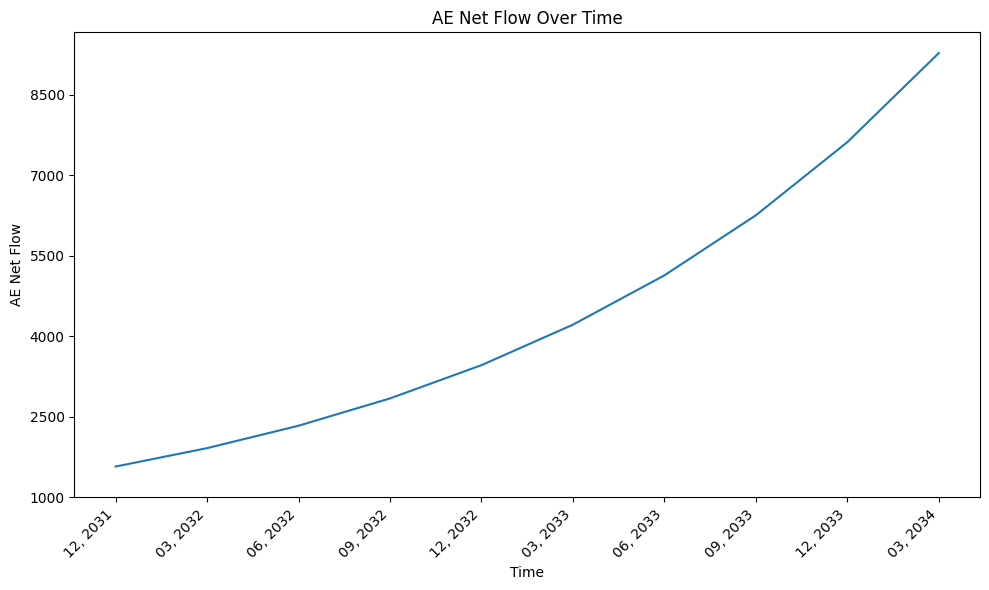

In [99]:
# Convert the 'Time (weeks)' column to datetime format
simulation_results_df['Time'] = pd.to_datetime(simulation_results_df['Time'], format='%d-%m-%Y')

# Calculate the maximum value rounded up to the nearest 500
max_value = math.ceil(simulation_results_df['AE Net Flow'].max() / 500) * 500

# Plotting the time series of AE Net Flow against Time
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(simulation_results_df['Time'], simulation_results_df['AE Net Flow'])

# Giving title to the chart using plt.title
plt.title('AE Net Flow Over Time')

# Set the number of x-axis tick labels to be displayed
num_tick_labels = 10  # Adjust as needed

# Choose indices for tick locations
tick_indices = np.linspace(0, len(simulation_results_df) - 1, num=num_tick_labels, dtype=int)

# Use tick_indices to set tick positions and labels
plt.xticks(simulation_results_df['Time'][tick_indices], simulation_results_df['Time'][tick_indices].dt.strftime('%m, %Y'), rotation=45, ha='right')

# Setting y-axis intervals to 500 starting from the first point of the graph
plt.yticks(np.arange(1000, max_value + 1, 1500))

# Providing x and y label to the chart
plt.xlabel('Time')
plt.ylabel('AE Net Flow')

# Display the plot
plt.tight_layout()
plt.show()

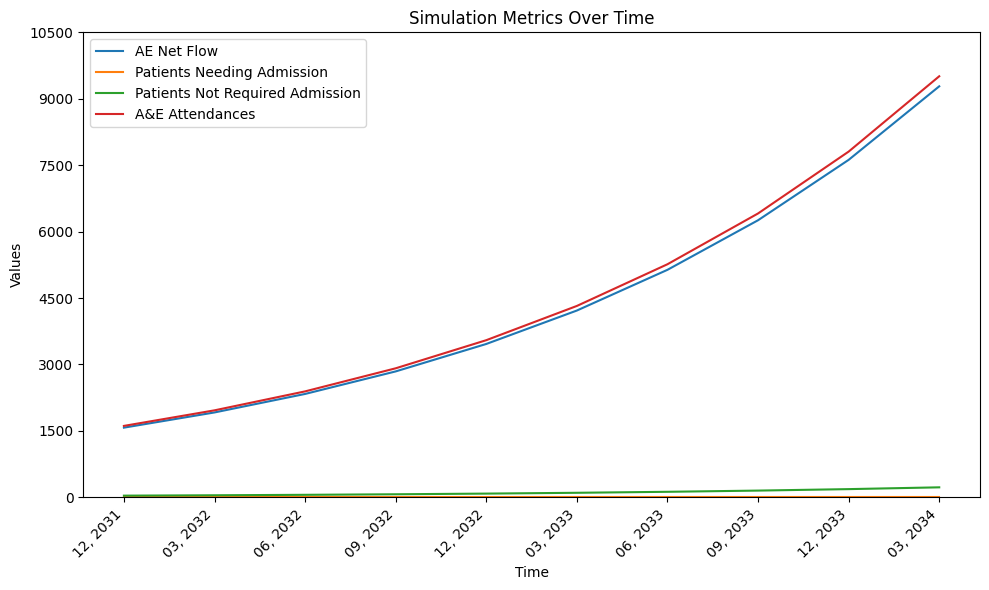

In [98]:
# Load the simulation results from the CSV file (replace 'simulation_results.csv' with your actual file name)
simulation_results_df = pd.read_csv('simulation_results.csv')

# Convert the 'Time (weeks)' column to datetime format
simulation_results_df['Time'] = pd.to_datetime(simulation_results_df['Time'], format='%d-%m-%Y')

# Calculate the maximum value rounded up to the nearest 500
max_value = math.ceil(simulation_results_df[['AE Net Flow', 'Patients Needing Admission', 'Patients Not Required Admission', 'A&E Attendances']].max().max() / 500) * 500

# Plotting the time series of different metrics against Time
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plotting AE Net Flow
plt.plot(simulation_results_df['Time'], simulation_results_df['AE Net Flow'], label='AE Net Flow')

# Plotting Patients Needing Admission
plt.plot(simulation_results_df['Time'], simulation_results_df['Patients Needing Admission'], label='Patients Needing Admission')

# Plotting Patients Not Required Admission
plt.plot(simulation_results_df['Time'], simulation_results_df['Patients Not Required Admission'], label='Patients Not Required Admission')

# Plotting A&E Attendances
plt.plot(simulation_results_df['Time'], simulation_results_df["A&E Attendances"], label='A&E Attendances')

# Giving title to the chart using plt.title
plt.title('Simulation Metrics Over Time')

# Set the number of x-axis tick labels to be displayed
num_tick_labels = 10  # Adjust as needed

# Choose indices for tick locations
tick_indices = np.linspace(0, len(simulation_results_df) - 1, num=num_tick_labels, dtype=int)

# Use tick_indices to set tick positions and labels
plt.xticks(simulation_results_df['Time'][tick_indices], simulation_results_df['Time'][tick_indices].dt.strftime('%m, %Y'), rotation=45, ha='right')

# Setting y-axis limits and intervals
plt.ylim(0, max_value + 500)  # Adjust the upper limit as needed
plt.yticks(np.arange(0, max_value + 1000, 1500))

# Providing x and y label to the chart
plt.xlabel('Time')
plt.ylabel('Values')

# Adding legends
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

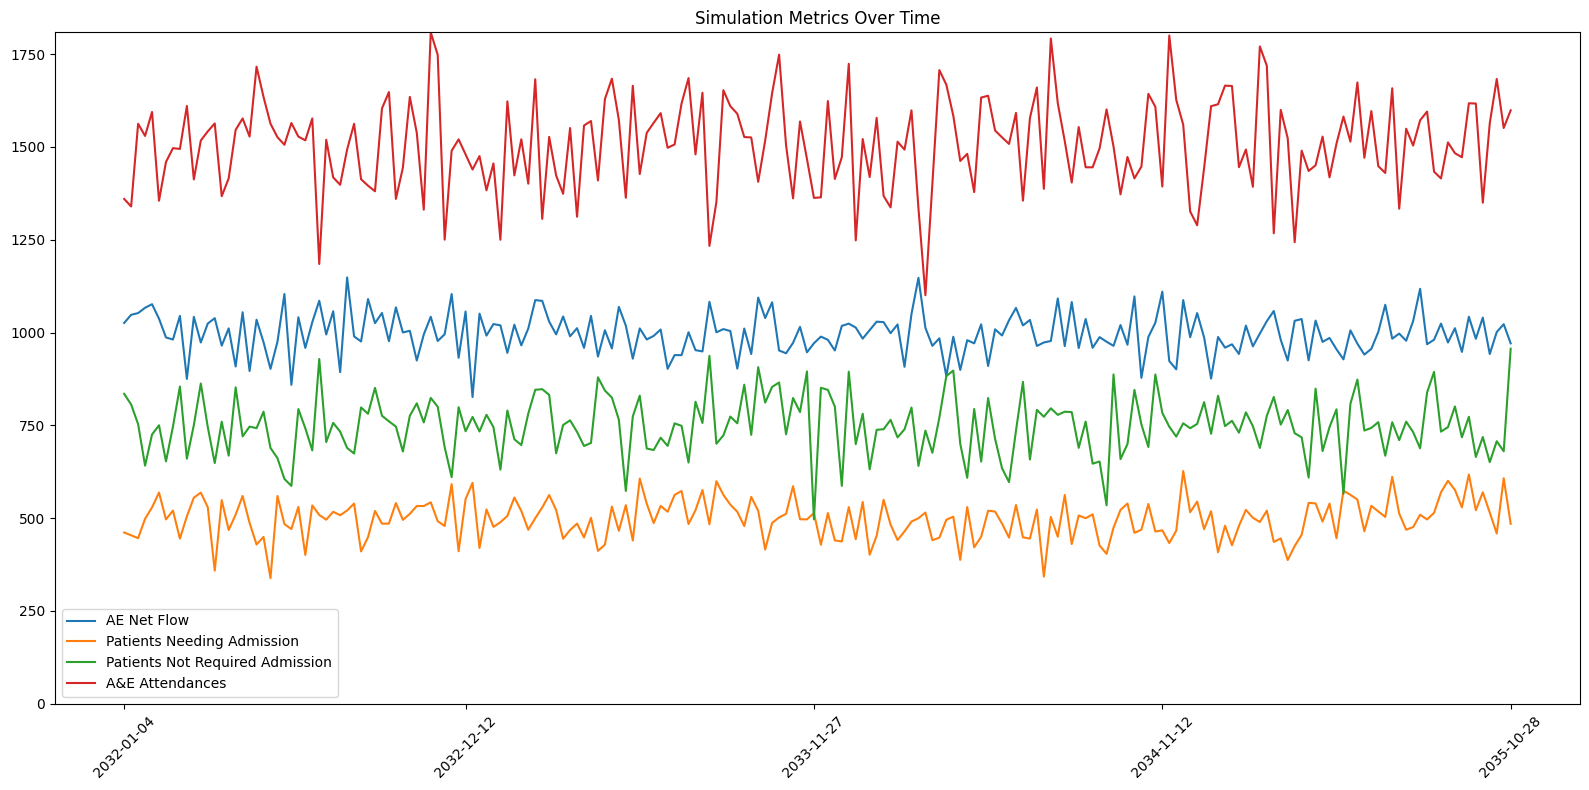

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
simulation_results_df = pd.DataFrame({'Time': pd.date_range('2032-01-01', periods=200, freq='W'),
                                      'AE Net Flow': np.random.randn(200)*50 + 1000,
                                      'Patients Needing Admission': np.random.randn(200)*50 + 500,
                                      'Patients Not Required Admission': np.random.randn(200)*75 + 750,
                                      'A&E Attendances': np.random.randn(200)*125 + 1500})

# Plot zoomed out view
plt.figure(figsize=(16,8))

plt.plot(simulation_results_df['Time'], simulation_results_df['AE Net Flow'], label='AE Net Flow')
plt.plot(simulation_results_df['Time'], simulation_results_df['Patients Needing Admission'], label='Patients Needing Admission')
plt.plot(simulation_results_df['Time'], simulation_results_df['Patients Not Required Admission'], label='Patients Not Required Admission')
plt.plot(simulation_results_df['Time'], simulation_results_df['A&E Attendances'], label='A&E Attendances')

num_tick_labels = 5
tick_indices = np.linspace(0, len(simulation_results_df)-1, num=num_tick_labels, dtype=int)
plt.xticks(simulation_results_df['Time'][tick_indices], rotation=45)

plt.ylim(0, simulation_results_df[['AE Net Flow', 'Patients Needing Admission', 'Patients Not Required Admission', 'A&E Attendances']].max().max())

plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.title('Simulation Metrics Over Time')

plt.tight_layout()
plt.show()